<h1>Predicting House Sale Prices</h1>

In the DataQuest course I have been gaining intuition for model based learning, and explored how the linear regression model works. Whilst studying the basics of linear regression, and the two approaches to model fitting (Gradient Descent, and Ordinary Least Squares), I have also picked up techniques for cleaning, transfomring and selecting features. The selection of appropriate features, and the transformation of features prior to creating a model is one of, if not the most, important steps.

In this project I am going to practice what I have learnt by trying to create a model for predicting house prices using the ASA dataset. In this notebook I will demonstrate how to transform features to make them suitable for modelling, and how to select features for the best performance.

I will start by exploring the dataset, and then setting up a pipeline of functions so I can quickly iterate on different models. I am going to demonstrate three seperate validation methods: holdout, k-fold cross-validation, and leave-one-out cross-validation.

In [3]:
#import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import KFold, train_test_split, cross_val_score, LeaveOneOut
from sklearn import preprocessing
import seaborn as sns

In [4]:
#Import the data into a pandas dataframe
data = pd.read_csv('AmesHousing.txt', delimiter='\t')

<h2>Data Exploration and Feature Transformation</h2>

The first step is to get some intuition as to what data I actually have here. I know from the start that my target column (i.e. my labels) is "SalePrice" but I want to chose the best features for my model, drop features that do not hold any valuable information, deal with missing data, and transform or even create new features where appropriate. To do all this I need to understand the dataset I am dealing with.

In [5]:
data.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000


In [6]:
data.shape

(2930, 82)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
Order              2930 non-null int64
PID                2930 non-null int64
MS SubClass        2930 non-null int64
MS Zoning          2930 non-null object
Lot Frontage       2440 non-null float64
Lot Area           2930 non-null int64
Street             2930 non-null object
Alley              198 non-null object
Lot Shape          2930 non-null object
Land Contour       2930 non-null object
Utilities          2930 non-null object
Lot Config         2930 non-null object
Land Slope         2930 non-null object
Neighborhood       2930 non-null object
Condition 1        2930 non-null object
Condition 2        2930 non-null object
Bldg Type          2930 non-null object
House Style        2930 non-null object
Overall Qual       2930 non-null int64
Overall Cond       2930 non-null int64
Year Built         2930 non-null int64
Year Remod/Add     2930 non-null int64
Roof Style         29

In [8]:
data.get_dtype_counts()

float64    11
int64      28
object     43
dtype: int64

Using the information from the pandas dataframe above, combined with the <a href="https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt">data documentation</a> it is clear that there is alot of categorical data. I will come back to these categorical columns later on.

For now, I am going to assess the following:
* How much missing data is there?
* Are there any columns that do not provide any meaningful information?

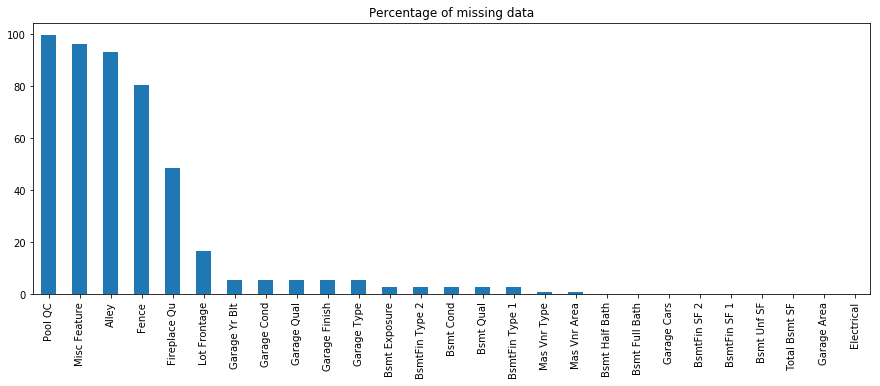

In [9]:
#Get columns with missing data
def show_missing_data():
    missing_data_columns = data.columns[data.isnull().any()]
    missing_data = data[missing_data_columns]
    percentage_missing_data = np.abs((missing_data.isnull().sum())/missing_data.shape[0] * 100)
    percentage_missing_data = percentage_missing_data.sort_values(ascending=False)
    percentage_missing_data.plot(kind='bar', figsize=(15,5), title="Percentage of missing data")
    plt.show()
show_missing_data()

The 'Misc Feature' column is for 'Miscellaneous feature not covered in other categories'. The majority of properties do not have any information for this columns, so I will just drop it.

As for the column 'Pool QC', the documentation states that a value of NA corresponds to 'No Pool'. This columns is categorical, and so if I replace the null values with the value 'No Pool' I can use this column later on. This will preserve information which might be useful for predicting sale prices. The same goes for 'Fireplace Qu', where a value of NA will instead be replaced with "No Fireplace".

A null value for the columns 'Alley' and the column 'Fence', which are both also categorical, represent no alley way access or no fence, respectively. I will therefore treat these columns in the same way as I have 'Pool QC' and 'Fireplace Qu'.

'Lot Frontage', which contains just under 20% missing data, is a bit more complicated. This column contains numerical data about the linear feet of street connexted to the property. One technique we can employ is imputation - replacing missing values with a descriptive statistic. Taking the average across the entire dataset will likely be misleading. The dataset does however contain information pertaining to the location of the property in the 'Neighbourhood' column. So what I will do instead is take the average 'Lot Frontage' for properties in each area, and replace missing values with this average in accordance to their 'Neighbourhood'.


In [10]:
#Drop the Misc Feature column
data = data.drop(['Misc Feature'], axis=1)

In [11]:
#Fill categorical data with None values
data['Pool QC'].fillna('No Pool', inplace=True)
data['Fireplace Qu'].fillna('No Fireplace', inplace=True)
data['Alley'].fillna('No Alley Access', inplace=True)
data['Fence'].fillna('No Fence', inplace=True)

In [12]:
#Replace null values with the average for the neighbourhood
data['Lot Frontage'] = data.groupby('Neighborhood')['Lot Frontage'].transform(lambda x: x.fillna(np.mean(x)))

In [13]:
data['Lot Frontage'].isnull().sum()

3

In [14]:
data[data['Lot Frontage'].isnull()]

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
2256,2257,916253320,120,RM,NaN,9763,Pave,No Alley Access,IR1,Lvl,...,0,0,No Pool,No Fence,0,9,2007,WD,Normal,330000
2788,2789,907230240,160,RH,NaN,3612,Pave,No Alley Access,IR1,Lvl,...,0,0,No Pool,MnPrv,0,6,2006,WD,Normal,137000
2892,2893,916252170,120,RM,NaN,8239,Pave,No Alley Access,IR1,Lvl,...,0,0,No Pool,No Fence,0,11,2006,WD,Normal,230000


As you can see in the cell above, there appears to still be three records with a null value for Lot Frontage. After further inspecition this appears to have occured because there is no Lot Frontage data for the neighborhoods that these three properties reside in. As there are only three records which are problematic, I shall just drop them.

In [15]:
data = data[data['Lot Frontage'].notnull()]

In [16]:
data['Lot Frontage'].isnull().sum()

0

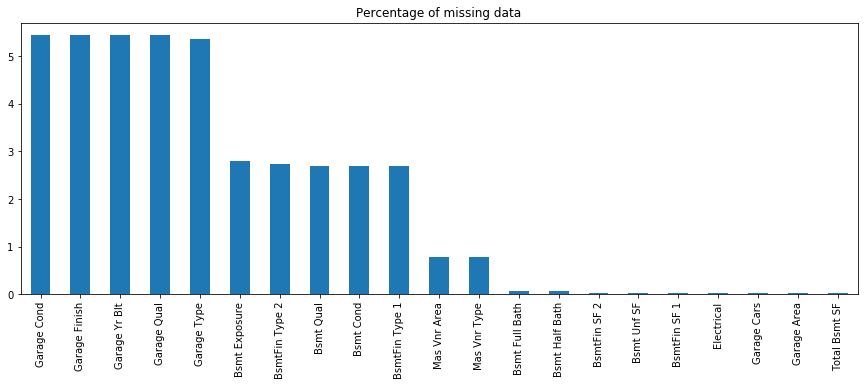

In [17]:
show_missing_data()

So now I have the question of what to do with the remaining missing data:
* Garage data: the missing values in the columns related to the garage is related to properties that have no garage. So for categorical data relating to the garage, I will replace the null values with "no garage", and the numerical values I will simply attribute a value of zero.
* Basement data: columns that begin with the prefix 'Bmst' relate to the basement. Like with the garage data, the missing values are attributed to properties with no basement.
* All other missing values after processing the above will be emitted from my dataset

In [18]:
#Amend garage data
data['Garage Cond'].fillna('No Garage', inplace=True)
data['Garage Finish'].fillna('No Garage', inplace=True)
data['Garage Yr Blt'].fillna(0, inplace=True)
data['Garage Qual'].fillna('No Garage', inplace=True)
data['Garage Type'].fillna('No Garage', inplace=True)
#Amend basement data
data['Bsmt Exposure'].fillna('No Basement', inplace=True)
data['BsmtFin Type 2'].fillna('No Basement', inplace=True)
data['Bsmt Qual'].fillna('No Basement', inplace=True)
data['Bsmt Cond'].fillna('No Basement', inplace=True)
data['BsmtFin Type 1'].fillna('No Basement', inplace=True)

In [19]:
data.dropna(inplace=True)

In [20]:
data.shape

(2900, 81)

In [21]:
data.isnull().sum().sum()

0

With all the missing values either replaced or removed, I will move on to removing features that do not provide any meaningful information, and remove these features before creating my model. 
By reading the data documentation I can see that the only column that doesn't relate directly to the property sales themselves is the PID column. This contains the 'Parcel identification number' which is just a value specific to the site where this data originates from. I will therefore drop the PID column.

Other features that may have less meaningful information are those with low variance i.e. more than 95% of the values in the column are the same. This might create bias towards a certain feature value. This is a bit arbitrary but I will just say that all columns whose values are 95% the same, I will drop.

In [22]:
#Drop PID
data.drop("PID", axis=1, inplace=True)

In [23]:
#Get columns where 95% of values are the same
low_var_columns = set()
for col in data:
    for vc in data[col].value_counts():
        if vc/data.shape[0] > 0.95:
            low_var_columns.add(col)

In [24]:
low_var_columns

{'3Ssn Porch',
 'Condition 2',
 'Heating',
 'Kitchen AbvGr',
 'Land Slope',
 'Low Qual Fin SF',
 'Misc Val',
 'Pool Area',
 'Pool QC',
 'Roof Matl',
 'Street',
 'Utilities'}

In [25]:
#Drop columns with low variance
data.drop(low_var_columns, axis=1,inplace=True)

The columns  MS SubClass is currently numerical but should be categorical, because its values have no semantic meaning. This column identifies the type of dwelling involved in the sale. Currently it contains a numerical value that represents a category specified in the data documentation. An increase in this value has no relation to the sale price. So I will transform this data into categorical datatype.

In [26]:
data['MS SubClass'] = data['MS SubClass'].astype('category')

<h2>Feature Selection</h2>

Now that I have dealt with missing data and removed irrelevant or misleading features, I will select the relevant features to use in my model.
When selecting features I will be focusing on the correlation between features and the target column. I can use the pandas function *.corr* to generate correlation coefficients.

I will first compute the correlation coefficient for each feature in relation to the Sale Price. I will then generate a correlation matrix using the *.corr* function. The correlation matrix will contain pairwise correlation coefficients for each pair of features within the dataset. I can observe the 'intensity' of each correlation by creating a heatmap.

After analysing which features most strongly correlate with the Sale Price, I will investigate any incidences of multicollinearity. Multicollinearity occurs when there is a strong intercorrelation between independant variables (feature columns). This can result in high standar error, and can be corrected by either:
* Removing the interrelated feature with the weakest correlation to the target column
* Combinging the interrelated features to create a new feature representative of both

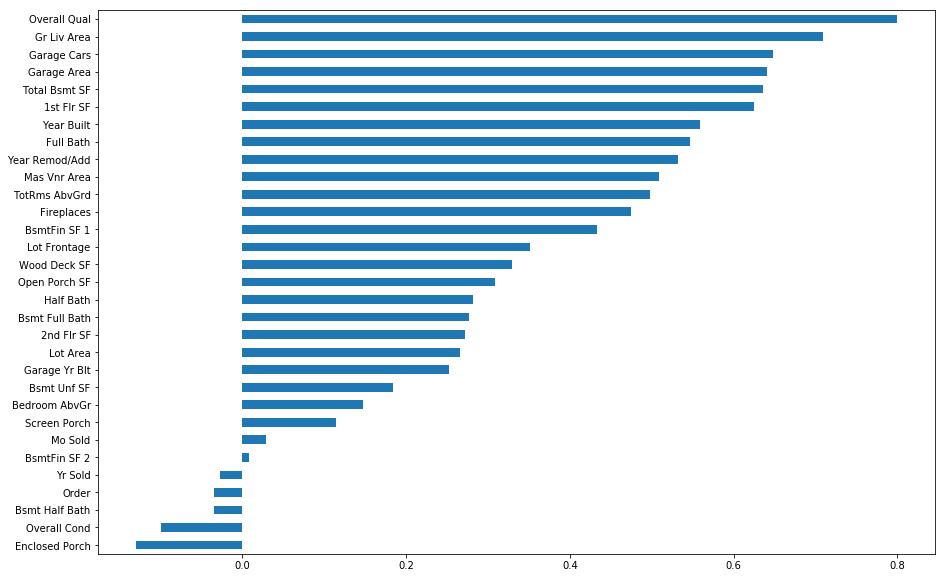

In [27]:
sale_corr = data.corr()['SalePrice'].sort_values()
sale_corr_plot = sale_corr.drop('SalePrice')
plt.figure(figsize=(15,10))
sale_corr_plot.plot(kind='barh')
plt.show()

It is rather arbitrary again, but I will chose a threshold correlation of 0.3 for my model, and therefore drop all features that fall below a correlation coefficient of 0.3. If the model performs poorly and demonstrates underfitting, then I can come back and try adding in more features.

In [28]:
def get_features(df, target_corr_coef, corr_threshold):
    return df[target_corr_coef[target_corr_coef > corr_threshold].index]
data_strong_features = get_features(data, sale_corr, 0.3)

I will now use the seaborn library to create a heatmap of a correlation coefficient matrix of my selected features

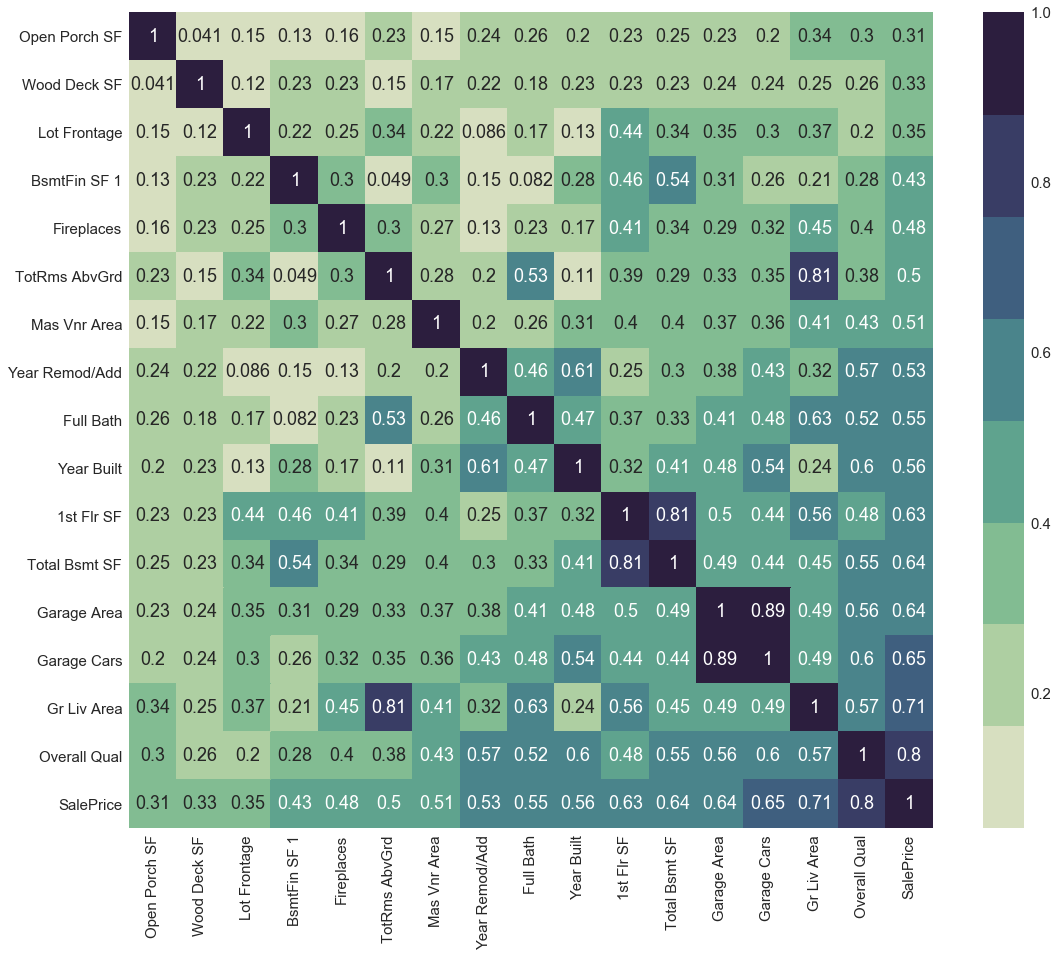

In [29]:
corr_matrix = data_strong_features.corr()
plt.figure(figsize=(18,15))
sns.set(font_scale=1.5)
sns.heatmap(corr_matrix, annot=True, cmap=sns.cubehelix_palette(8, start=.5, rot=-.75))
plt.show()

Highly correlated features include the following pairs of features:
* TotRmsAbvGrd and Gr Liv Area
* 1st Flr SF and Total Bsmt SF
* Garage Area and Garage Cars
These pairs are highly correlated because they both describe very similar information.

The following featurres have a high correlation because both features essentially quantify the living space on the first floor:
* TotRmsAbvGrd = Toal rooms above grade (ground)
* Gr Liv Area = Above grade living area

I will drop TotRmsAbvGrd as Gr Liv Area has a stronger correlation with SalePrice

The correlation for the following features correlate highly because they both describe the surface area defined by the perimeter of the property:
* 1st Floor SF = First Floor square feet
* Total Bsmt SF = Total square feet of basement area

Total Bsmt SF has a slightly higher correlation with SalePrice, so I will drop 1st Floor SF.

Finally, the Garage Area and Garage Cars (number of cars the garage fits) both describe the size of the garage. Either feature could be kept, but Garage Cars has a slightly stronger correlation with SalePrice and so I shall keep this feature over Garage Area.

In [30]:
data.drop(['TotRms AbvGrd', '1st Flr SF', 'Garage Area'], axis=1, inplace=True)

In [31]:
#Select highly correlated numerical columns, whilst preserving categorical data
sale_corr = data.corr()['SalePrice']
columns_to_drop = sale_corr[sale_corr < 0.3].index.values

In [32]:
data_selected_features = data.drop(columns_to_drop, axis=1)

<h2>Dummy codes and normalisation</h2>

Now I have selected my feature columns the last step is to create dummy codes for my categorical data.

Dummy codes are created to convert categorical features into numerical ones. For each unique value in a categorical column, a new column is created. A binary value is associated to each dummy column which represents if a row is classified by the unique value that the column represents.

In [33]:
#Create dummies
data_selected_features = pd.get_dummies(data_selected_features)

In [34]:
data_selected_features.shape

(2900, 269)

In [56]:
data_selected_features = data_selected_features.reset_index(drop=True)

<h2>Creating the Linear Regression Model</h2>

For the linear regression model I am going to be using the sklearn library. The function I am writing below also allows for the use of different validation methods.

When we are training a machine learning model we split our data into train and test subsets. We then fit our model using the train subset and measure its performance by making predictions on the test subset. When we train a model, one of two things may occur:
* Overfitting: this is when our model has fit the training data too closely, and even begins to model random noise. This usually occurs when the model is too complex (too many features) and although it will be very accurate on the training data, it will not perfom well in validation. The model has not **generalised** well. Meaning that it cannot make predictions on data other than the data it has been trained on.
* Underfitting: when a model is underfitting, it means that the model does not fit the training data. It also means that it cannot generalise to new data, but this time it is because it has failed to capture the relationships that underpin the features and targets. It can also occur when we try and fit a linear regression model to data that is not linear. It can also suggest that our model is too simple, and requires more features.

In the function below there are three methods that I will demonstrate:

* Holdout: this is a simple test/train split, where data is split evenly between test and train subsets. The model is trained on the train subset, and tested on the test subset. Holdout increases the risk of overfitting, as the training data might contain very different data to the test dataset.

* K-Fold Cross-Validation: in order to reduce overfitting, data is split into k subsets (also called folds), and trained on k-1 of those subsets. The left over subset is used for testing. We then iterate over each k subset until every one has been used for testing, and then average the model against each of the folds (subsets) to get our final model.

* Leave One Out Cross Validation (LOOCV): the number of folds we use equals the number of observations we have in the dataset. The average of all the folds is taken and we build our model with the average. Testing is then made against the last fold. This method is very computationally expensive, and should only be used on small datasets.

How many folds should we use? This is more of an art, and is something we have to experiment with. The more folds you have, the greater reduction in error due to bias, but an increased amount of error due to variance. Also more folds = more computational cost. With big datasets it is recommended to use k=3, and with smaller datasets it is recommended to use LOOCV.

In [74]:
def train_and_test(df, target,cv_type='kfold',n_folds=3):
    x = df.drop(target,axis=1)
    y = df[target]
    
    
    if cv_type == 'None':
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=1)
        model = LinearRegression()
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        rmse = np.sqrt(mse(predictions, y_test))
        return(rmse, model.score(x_train,y_train))
    
    elif cv_type == 'kfold':
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)
        print(df.index)
        rmses = []
        scores = []
        for train_index, test_index in kf.split(df):
            train, test = df.loc[train_index], df.loc[test_index]
            
            train_x = train.drop(target,axis=1)
            train_y = train[target]
            test_x = train.drop(target,axis=1)
            test_y = train[target]
            
            model = LinearRegression()
            model.fit(train_x, train_y)
            predictions = model.predict(test_x)
            rmses.append(np.sqrt(mse(predictions, test_y)))
            scores.append(model.score(train_x, train_y))
        return(np.mean(rmses), np.mean(scores))
    
    elif cv_type == 'LOOCV':
        loocv = LeaveOneOut()
        model = LinearRegression()
        rmse = np.mean(cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=loocv))
        return(rmse)

In [75]:
train_and_test(data_selected_features, 'SalePrice', cv_type='None')

(28743.878866370946, 0.90613976944351704)

In [76]:
train_and_test(data_selected_features, 'SalePrice', cv_type='kfold')

RangeIndex(start=0, stop=2900, step=1)


(24586.475745500877, 0.90492096164585967)

As you can see, the results are rubbish! Also, the holdout validation has clearly demonstrated what I had explained previously. The holdout validation fails to demostrate that the model is flawed, and will not generalise well to a 

In [62]:
data_selected_features

,Lot Frontage,Overall Qual,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,Gr Liv Area,Full Bath,Fireplaces,...,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_Abnorml,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal,Sale Condition_Partial
0,141.000000,6,1960,1960,112.0,639.0,1080.0,1656,1,2,...,0,0,0,1,0,0,0,0,1,0
1,80.000000,5,1961,1961,0.0,468.0,882.0,896,1,0,...,0,0,0,1,0,0,0,0,1,0
2,81.000000,6,1958,1958,108.0,923.0,1329.0,1329,1,0,...,0,0,0,1,0,0,0,0,1,0
3,93.000000,7,1968,1968,0.0,1065.0,2110.0,2110,2,2,...,0,0,0,1,0,0,0,0,1,0
4,74.000000,5,1997,1998,0.0,791.0,928.0,1629,2,1,...,0,0,0,1,0,0,0,0,1,0
5,78.000000,6,1998,1998,20.0,602.0,926.0,1604,2,1,...,0,0,0,1,0,0,0,0,1,0
6,41.000000,8,2001,2001,0.0,616.0,1338.0,1338,2,0,...,0,0,0,1,0,0,0,0,1,0
7,43.000000,8,1992,1992,0.0,263.0,1280.0,1280,2,0,...,0,0,0,1,0,0,0,0,1,0
8,39.000000,8,1995,1996,0.0,1180.0,1595.0,1616,2,1,...,0,0,0,1,0,0,0,0,1,0
9,60.000000,7,1999,1999,0.0,0.0,994.0,1804,2,1,...,0,0,0,1,0,0,0,0,1,0
